<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_EURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 1.73 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 14:40:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 97 kB 1.7 MB/s 
     |████████████████████████████████| 170 kB 57.7 MB/s 
     |████████████████████████████████| 138 kB 52.1 MB/s 
     |████████████████████████████████| 133 kB 61.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: szlj5cf4
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/szlj5cf4


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: e8hexgon with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 15s 107ms/step - loss: 0.1730 - mean_squared_error: 0.1730 - mean_absolute_error: 0.3210 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1427
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1377 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1126
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0915 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0998
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0668 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0876
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0

epoch,69
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01401
val_loss,0.00207
val_mean_squared_error,0.00207
val_mean_absolute_error,0.03677
_runtime,32
_timestamp,1627051311
_step,69
best_val_loss,0.00205


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hrvhmhic with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 2s 24ms/step - loss: 0.1620 - mean_squared_error: 0.1620 - mean_absolute_error: 0.2985 - val_loss: 0.0799 - val_mean_squared_error: 0.0799 - val_mean_absolute_error: 0.2065
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - mean_absolute_error: 0.2013 - val_loss: 0.0574 - val_mean_squared_error: 0.0574 - val_mean_absolute_error: 0.1850
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1826 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1630
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1553 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1315
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0196 - mean_squared_error: 0.

epoch,49
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02766
val_loss,0.00567
val_mean_squared_error,0.00567
val_mean_absolute_error,0.05757
_runtime,17
_timestamp,1627051340
_step,49
best_val_loss,0.00567


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1n9s9bdz with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 42ms/step - loss: 1.5308 - mean_squared_error: 1.5308 - mean_absolute_error: 0.8143 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1097
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0834 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1203
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1402 - val_loss: 0.4495 - val_mean_squared_error: 0.4495 - val_mean_absolute_error: 0.6257
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1707 - mean_squared_error: 0.1707 - mean_absolute_error: 0.2542 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1136
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0123 - mean_squared_erro

epoch,64
loss,0.0026
mean_squared_error,0.0026
mean_absolute_error,0.0365
val_loss,0.0163
val_mean_squared_error,0.0163
val_mean_absolute_error,0.10134
_runtime,15
_timestamp,1627051375
_step,64
best_val_loss,0.00326


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▁▁▃▃▃▂▂▃▂▂▄▁▂▁▃▁▂▂▃▁▁▂▂▂▁▁▁▂▂▂▁▁▁
val_loss,▁▂▂▁▁▂▅▁▂▂▃▃▁▁▅▁▁█▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▂▂▁▁▂▅▁▂▂▃▃▁▁▅▁▁█▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂▂▂▃▆▁▃▃▅▄▁▁▆▂▂█▁▁▆▂▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1vyzicto with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 26ms/step - loss: 0.1066 - mean_squared_error: 0.1066 - mean_absolute_error: 0.2328 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0957
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0456 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0687
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0360 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0599
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0304 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0500
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_squared_error: 0.

epoch,47
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01393
val_loss,0.00213
val_mean_squared_error,0.00213
val_mean_absolute_error,0.03666
_runtime,19
_timestamp,1627051406
_step,47
best_val_loss,0.00209


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: f54pamco with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 22ms/step - loss: 10.8468 - mean_squared_error: 10.8468 - mean_absolute_error: 1.9157 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1250
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1075 - val_loss: 14.6264 - val_mean_squared_error: 14.6264 - val_mean_absolute_error: 3.6276
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 5.8278 - mean_squared_error: 5.8278 - mean_absolute_error: 1.2381 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0869
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0757 - val_loss: 0.0792 - val_mean_squared_error: 0.0792 - val_mean_absolute_error: 0.2286
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.9925 - mean_squared_error

epoch,21
loss,0.06157
mean_squared_error,0.06157
mean_absolute_error,0.14427
val_loss,0.02246
val_mean_squared_error,0.02246
val_mean_absolute_error,0.11419
_runtime,11
_timestamp,1627051430
_step,21
best_val_loss,0.00689


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▄▁▂▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▄▁▂▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▁▃▃▁▄▁▂▁▂▂▁▁▂▁▁▂▁▁▁
val_loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇████
_timestamp,▁▂▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: yemvqmor with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 84ms/step - loss: 0.6685 - mean_squared_error: 0.6685 - mean_absolute_error: 0.6288 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1218
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0888 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0986
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0876
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0439 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0923
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error: 0.002

epoch,98
loss,0.00062
mean_squared_error,0.00062
mean_absolute_error,0.0193
val_loss,0.00368
val_mean_squared_error,0.00368
val_mean_absolute_error,0.04876
_runtime,17
_timestamp,1627051461
_step,98
best_val_loss,0.00361


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c23xmyxs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 44ms/step - loss: 31.0056 - mean_squared_error: 31.0056 - mean_absolute_error: 2.1925 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1396
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1318 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - val_mean_absolute_error: 0.2344
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1117 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0880
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0975 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0907
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0146 - mean_squared_er

epoch,45
loss,0.00603
mean_squared_error,0.00603
mean_absolute_error,0.05369
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.05874
_runtime,14
_timestamp,1627051488
_step,45
best_val_loss,0.00408


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▆▁▁█▂▄▃█▂▂▁▁▂▂▁▁▁▂▁▂▁▁▃▁▁▃▁▁▁▁▁▂▁▁▂▁▂▁▁
val_mean_squared_error,▂▆▁▁█▂▄▃█▂▂▁▁▂▂▁▁▁▂▁▂▁▁▃▁▁▃▁▁▁▁▁▂▁▁▂▁▂▁▁
val_mean_absolute_error,▃▆▂▂█▃▄▃▇▃▂▂▂▂▂▁▁▁▃▁▃▁▁▃▁▁▄▁▁▁▁▁▂▁▁▃▂▃▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: g5p21x7f with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 82ms/step - loss: 0.1188 - mean_squared_error: 0.1188 - mean_absolute_error: 0.2404 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0920
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0625 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0781
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0415 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1140
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0827 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0726
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - 

epoch,26
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.02965
val_loss,0.01203
val_mean_squared_error,0.01203
val_mean_absolute_error,0.0835
_runtime,9
_timestamp,1627051509
_step,26
best_val_loss,0.00632


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▁▂▂▁▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▂▁▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▃▃▃▃▃▂▃▂▂▂▂▂▃▁▂▂▂▂▂▂▂▂▁
val_loss,▄▃▇▂██▆▃▄▄▂▂▄▅▅▄▁▆▃▄▃▃▂▃▁▁▃
val_mean_squared_error,▄▃▇▂██▆▃▄▄▂▂▄▅▅▄▁▆▃▄▃▃▂▃▁▁▃
val_mean_absolute_error,▄▃▇▂██▆▃▅▄▂▂▄▆▅▄▁▇▄▅▃▃▂▃▁▂▄
_runtime,▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆███
_timestamp,▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: k8i1w9nn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 44ms/step - loss: 334.3964 - mean_squared_error: 334.3964 - mean_absolute_error: 13.1000 - val_loss: 21.9153 - val_mean_squared_error: 21.9153 - val_mean_absolute_error: 4.4384
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 11.4972 - mean_squared_error: 11.4972 - mean_absolute_error: 2.8278 - val_loss: 16.4512 - val_mean_squared_error: 16.4512 - val_mean_absolute_error: 4.0267
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 6.4321 - mean_squared_error: 6.4321 - mean_absolute_error: 2.2576 - val_loss: 1.8013 - val_mean_squared_error: 1.8013 - val_mean_absolute_error: 1.0484
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 2.6939 - mean_squared_error: 2.6939 - mean_absolute_error: 1.1734 - val_loss: 2.7076 - val_mean_squared_error: 2.7076 - val_mean_absolute_error: 1.5509
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 2.6218 - mean

epoch,21
loss,0.13767
mean_squared_error,0.13767
mean_absolute_error,0.30542
val_loss,0.14589
val_mean_squared_error,0.14589
val_mean_absolute_error,0.2835
_runtime,10
_timestamp,1627051532
_step,21
best_val_loss,0.08027


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▇▂▃▂▂▁▁▂▁▁▁▁▁▁▁▁▃▂▂▁▁
_runtime,▁▁▁▁▃▃▃▃▃▆▆▆▆▆▆███████
_timestamp,▁▁▁▁▃▃▃▃▃▆▆▆▆▆▆███████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: pyugaz5j with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 81ms/step - loss: 30470.0091 - mean_squared_error: 30470.0091 - mean_absolute_error: 86.3465 - val_loss: 25.7929 - val_mean_squared_error: 25.7929 - val_mean_absolute_error: 4.9055
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 11.1323 - mean_squared_error: 11.1323 - mean_absolute_error: 2.6686 - val_loss: 1.0160 - val_mean_squared_error: 1.0160 - val_mean_absolute_error: 0.9171
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 1.7902 - mean_squared_error: 1.7902 - mean_absolute_error: 1.0991 - val_loss: 10.9533 - val_mean_squared_error: 10.9533 - val_mean_absolute_error: 3.2573
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 135.5851 - mean_squared_error: 135.5851 - mean_absolute_error: 9.0500 - val_loss: 0.3723 - val_mean_squared_error: 0.3723 - val_mean_absolute_error: 0.4901
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0321 - mean_

epoch,43
loss,0.92269
mean_squared_error,0.92269
mean_absolute_error,0.55145
val_loss,0.06663
val_mean_squared_error,0.06663
val_mean_absolute_error,0.18486
_runtime,11
_timestamp,1627051557
_step,43
best_val_loss,0.01582


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▁▁▂▂▁▁▁▄▁▁▁▁▁▁▅▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆█████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6eukz0mc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 24ms/step - loss: 25.5610 - mean_squared_error: 25.5610 - mean_absolute_error: 1.7046 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - val_mean_absolute_error: 0.2808
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.1285 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - val_mean_absolute_error: 0.2257
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1210 - val_loss: 0.1940 - val_mean_squared_error: 0.1940 - val_mean_absolute_error: 0.3523
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.1010 - mean_squared_error: 0.1010 - mean_absolute_error: 0.2279 - val_loss: 0.0646 - val_mean_squared_error: 0.0646 - val_mean_absolute_error: 0.1917
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0378 - mean_squared_error: 

epoch,49
loss,0.00409
mean_squared_error,0.00409
mean_absolute_error,0.04193
val_loss,0.00373
val_mean_squared_error,0.00373
val_mean_absolute_error,0.0486
_runtime,20
_timestamp,1627051590
_step,49
best_val_loss,0.00291


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃█▃▂▃▂▂▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▅▃█▃▂▃▂▂▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▆▅█▄▃▄▃▃▂▂▁▁▃▄▁▁▁▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▃▂▁▂▂▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gxiy5ygb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 24ms/step - loss: 0.1467 - mean_squared_error: 0.1467 - mean_absolute_error: 0.2065 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1444
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0790 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1851
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1013 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0659
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0622 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0681
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0109 - mean_squared_erro

epoch,38
loss,0.00148
mean_squared_error,0.00148
mean_absolute_error,0.02799
val_loss,0.00351
val_mean_squared_error,0.00351
val_mean_absolute_error,0.0458
_runtime,17
_timestamp,1627051620
_step,38
best_val_loss,0.00299


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▆▄▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁
val_loss,▅█▂▂▃▁▁▂▅▄▁▂▁▁▁▁▁▄▁▂▁▁▃▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▅█▂▂▃▁▁▂▅▄▁▂▁▁▁▁▁▄▁▂▁▁▃▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▆█▂▂▄▂▂▂▆▅▁▂▁▂▁▁▂▅▁▃▁▁▄▂▃▁▃▂▁▁▁▂▁▁▁▂▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rx23e7f8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 25ms/step - loss: 0.1545 - mean_squared_error: 0.1545 - mean_absolute_error: 0.2906 - val_loss: 0.0559 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.1856
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1915 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1487
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1345 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1090
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0733 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0837
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_squared_erro

epoch,52
loss,0.00167
mean_squared_error,0.00167
mean_absolute_error,0.0319
val_loss,0.00753
val_mean_squared_error,0.00753
val_mean_absolute_error,0.06507
_runtime,20
_timestamp,1627051653
_step,52
best_val_loss,0.00751


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rnm8y702 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 24ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error:

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627051678
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▁▅▅▅▅██
_timestamp,▁▁▁▁▅▅▅▅██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 9g7rqb0c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 42ms/step - loss: 0.0621 - mean_squared_error: 0.0621 - mean_absolute_error: 0.1635 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0835
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0648 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0762
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0511 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0902
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0507 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0653
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.

epoch,49
loss,0.00203
mean_squared_error,0.00203
mean_absolute_error,0.0346
val_loss,0.01008
val_mean_squared_error,0.01008
val_mean_absolute_error,0.07777
_runtime,14
_timestamp,1627051709
_step,49
best_val_loss,0.00342


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▂▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▂
val_loss,▅▅▆▃▄▇▇▄▂▂▅▆█▅▃▃▂▃▃▆▆▂▄▁▆▂▂▃▂▁▁▁▁▃▆▂▁▁▂▅
val_mean_squared_error,▅▅▆▃▄▇▇▄▂▂▅▆█▅▃▃▂▃▃▆▆▂▄▁▆▂▂▃▂▁▁▁▁▃▆▂▁▁▂▅
val_mean_absolute_error,▆▅▇▄▃▇▇▃▂▃▆▇█▅▃▃▂▄▄▇▆▃▅▂▆▂▂▃▂▁▂▁▁▄▇▂▁▁▂▅
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: flp3qtk3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 82ms/step - loss: 0.1702 - mean_squared_error: 0.1702 - mean_absolute_error: 0.3142 - val_loss: 0.1171 - val_mean_squared_error: 0.1171 - val_mean_absolute_error: 0.2504
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0781 - mean_squared_error: 0.0781 - mean_absolute_error: 0.1953 - val_loss: 0.0642 - val_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.2177
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0695 - mean_squared_error: 0.0695 - mean_absolute_error: 0.2336 - val_loss: 0.0600 - val_mean_squared_error: 0.0600 - val_mean_absolute_error: 0.1953
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - mean_absolute_error: 0.1999 - val_loss: 0.0526 - val_mean_squared_error: 0.0526 - val_mean_absolute_error: 0.1770
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - me

epoch,49
loss,0.00134
mean_squared_error,0.00134
mean_absolute_error,0.02855
val_loss,0.00636
val_mean_squared_error,0.00636
val_mean_absolute_error,0.06027
_runtime,12
_timestamp,1627051736
_step,49
best_val_loss,0.00636


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 60x0ooxs with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 87ms/step - loss: 0.4985 - mean_squared_error: 0.4985 - mean_absolute_error: 0.5124 - val_loss: 0.4289 - val_mean_squared_error: 0.4289 - val_mean_absolute_error: 0.6465
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: inf - mean_squared_error: inf - mean_absolute_error: 9277606826508893489610274746925056.0000 - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error:

epoch,10
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627051759
_step,10
best_val_loss,0.4289


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▁
mean_squared_error,▁
mean_absolute_error,▁█
val_loss,▁
val_mean_squared_error,▁
val_mean_absolute_error,▁
_runtime,▁▁▁▁▁▁▁████
_timestamp,▁▁▁▁▁▁▁████
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: r3kpicte with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 84ms/step - loss: 0.1450 - mean_squared_error: 0.1450 - mean_absolute_error: 0.2693 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1335
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1090 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0757
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0486 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1111
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0665 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1174
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0099 - mean_squared_error: 0.0099 -

epoch,49
loss,0.00195
mean_squared_error,0.00195
mean_absolute_error,0.03312
val_loss,0.00504
val_mean_squared_error,0.00504
val_mean_absolute_error,0.05428
_runtime,14
_timestamp,1627051787
_step,49
best_val_loss,0.00371


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▃▂▂▃▂▃▂▂▂▂▃▁▁▂▁▂▂▁▁▁▂▃▁▁▁▁▁▂▁▁▁▂▂▁
val_loss,█▃▆▇▃▆▃▄▅▂▄▂▄▄▄▄▁▁▁▂▁▁▁▁▁▁▅▂▁▁▁▁▁▁▁▁▃▆▂▁
val_mean_squared_error,█▃▆▇▃▆▃▄▅▂▄▂▄▄▄▄▁▁▁▂▁▁▁▁▁▁▅▂▁▁▁▁▁▁▁▁▃▆▂▁
val_mean_absolute_error,█▃▆▇▃▆▃▄▅▂▅▂▄▄▄▄▂▂▂▂▂▂▂▂▁▂▅▂▁▂▂▂▂▁▁▁▃▆▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: u8kq21xy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 0.0901 - mean_squared_error: 0.0901 - mean_absolute_error: 0.1848 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0670
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0391 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0633
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0379 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0572
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0465 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0870
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_e

epoch,60
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01821
val_loss,0.00265
val_mean_squared_error,0.00265
val_mean_absolute_error,0.04127
_runtime,30
_timestamp,1627051835
_step,60
best_val_loss,0.00255


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▂▂▂▂▂▂▂▂▂▁▃▂▁▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▃▂▂▁▁▁▁▁▃▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▃▂▂▁▁▁▁▁▃▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃▄▂▂▂▂▁▂▁▄▁▁█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: d5md3ovq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 79ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - v

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,8
_timestamp,1627051857
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁███████
_timestamp,▁▁▁███████
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: doamvxkj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 88ms/step - loss: 118.3894 - mean_squared_error: 118.3894 - mean_absolute_error: 6.4126 - val_loss: 13.8409 - val_mean_squared_error: 13.8409 - val_mean_absolute_error: 3.2224
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 41.1643 - mean_squared_error: 41.1643 - mean_absolute_error: 5.5011 - val_loss: 6.3207 - val_mean_squared_error: 6.3207 - val_mean_absolute_error: 2.4953
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 4.4573 - mean_squared_error: 4.4573 - mean_absolute_error: 1.8440 - val_loss: 1.4814 - val_mean_squared_error: 1.4814 - val_mean_absolute_error: 0.8867
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 3.3891 - mean_squared_error: 3.3891 - mean_absolute_error: 1.5029 - val_loss: 8.0037 - val_mean_squared_error: 8.0037 - val_mean_absolute_error: 2.6466
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 5.8301 - mean_squared_err

epoch,14
loss,7.17177
mean_squared_error,7.17177
mean_absolute_error,1.5597
val_loss,1.01324
val_mean_squared_error,1.01324
val_mean_absolute_error,0.98522
_runtime,10
_timestamp,1627051883
_step,14
best_val_loss,0.10632


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▁▁▁▁▁▁▁▁▁▂▂▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▂▂▁▁
mean_absolute_error,█▅▂▂▂▁▂▁▁▂▂▃▂▂▂
val_loss,█▄▂▅▁▄▁▂▃▄█▅▆▄▁
val_mean_squared_error,█▄▂▅▁▄▁▂▃▄█▅▆▄▁
val_mean_absolute_error,▇▅▂▆▁▅▂▄▄▆█▅▇▄▂
_runtime,▁▁▅▅▅▅▅▅▅▅▅████
_timestamp,▁▁▅▅▅▅▅▅▅▅▅████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: zwjqa0d2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 85ms/step - loss: 169.7161 - mean_squared_error: 169.7161 - mean_absolute_error: 8.4882 - val_loss: 432.1336 - val_mean_squared_error: 432.1336 - val_mean_absolute_error: 20.6951
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 191.8920 - mean_squared_error: 191.8920 - mean_absolute_error: 12.3799 - val_loss: 16.9574 - val_mean_squared_error: 16.9574 - val_mean_absolute_error: 3.6566
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 7.1156 - mean_squared_error: 7.1156 - mean_absolute_error: 2.0899 - val_loss: 10.6088 - val_mean_squared_error: 10.6088 - val_mean_absolute_error: 2.8239
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 9.5483 - mean_squared_error: 9.5483 - mean_absolute_error: 2.4921 - val_loss: 1.8623 - val_mean_squared_error: 1.8623 - val_mean_absolute_error: 1.1906
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 4.6245 - mean_square

epoch,19
loss,0.13212
mean_squared_error,0.13212
mean_absolute_error,0.29796
val_loss,0.15811
val_mean_squared_error,0.15811
val_mean_absolute_error,0.29828
_runtime,10
_timestamp,1627051912
_step,19
best_val_loss,0.10104


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▂▂▂▂▂▃▂▂▂▁▂▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅███
_timestamp,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅███
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: ih1ti5p6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 0.3638 - mean_squared_error: 0.3638 - mean_absolute_error: 0.3324 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0947
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0748 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1289
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0791 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0726
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0523 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0815
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_e

epoch,41
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.02557
val_loss,0.00449
val_mean_squared_error,0.00449
val_mean_absolute_error,0.05302
_runtime,24
_timestamp,1627051953
_step,41
best_val_loss,0.00281


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▂▂▂▂▂▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▄▄▂▃▂▂▂▃▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▄█▃▄▄▂▃▂▂▂▃▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▅█▃▄▄▃▄▂▃▂▄▂▂▃▂▂▁▂▁▂▁▁▂▁▁▁▂▁▂▂▁▁▁▁▁▁▃▂▂▂
_runtime,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: bqh3ycd1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 3s 39ms/step - loss: 0.1639 - mean_squared_error: 0.1639 - mean_absolute_error: 0.2420 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0860
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0544 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0653
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0366 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0579
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0373 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0574
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_er

epoch,47
loss,0.00335
mean_squared_error,0.00335
mean_absolute_error,0.04368
val_loss,0.00315
val_mean_squared_error,0.00315
val_mean_absolute_error,0.04475
_runtime,22
_timestamp,1627051996
_step,47
best_val_loss,0.00201


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▂▁▁▁▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃
val_loss,▅▃▃▂▂▂▂▂▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁█▁
val_mean_squared_error,▅▃▃▂▂▂▂▂▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁█▁
val_mean_absolute_error,▅▄▃▃▂▃▂▂▂▂▁▂▂▂▃▂▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁█▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ecsy18v9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 2s 23ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan 

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,10
_timestamp,1627052023
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▅▅▅▅███
_timestamp,▁▁▁▅▅▅▅███
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 3gnou63w with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 91ms/step - loss: 0.1084 - mean_squared_error: 0.1084 - mean_absolute_error: 0.2349 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1683
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0873 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1253
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0732 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0825
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0518 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1026
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046 -

epoch,38
loss,0.003
mean_squared_error,0.003
mean_absolute_error,0.04319
val_loss,0.00501
val_mean_squared_error,0.00501
val_mean_absolute_error,0.0577
_runtime,15
_timestamp,1627052053
_step,38
best_val_loss,0.00381


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▃▂▂▂▃▂▃▂▂▂▃▁▂▂▂▂▁▁▂▁▁▁▂▂▂▂▁▁▂▁▂▂
val_loss,█▅▃▄▅▂▄▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂▁
val_mean_squared_error,█▅▃▄▅▂▄▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂▁
val_mean_absolute_error,█▅▃▄▅▂▄▂▂▃▂▂▂▂▂▂▃▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: sbqgilo1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 46ms/step - loss: 0.1313 - mean_squared_error: 0.1313 - mean_absolute_error: 0.2551 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0803
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0404 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0729
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0456 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0726
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0450 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0982
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0066 - mean_squared_error

epoch,49
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02242
val_loss,0.00333
val_mean_squared_error,0.00333
val_mean_absolute_error,0.0462
_runtime,19
_timestamp,1627052087
_step,49
best_val_loss,0.00329


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▂▁▂▂▁▂▁▂▁▂▁▂▁▂▁▁▂▁▂▂▁▂▁▁▁▁▁▁▂▁▁
val_loss,▄▃▃▆█▂▃▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▃▃▆█▂▃▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄▄▆█▂▃▂▂▂▂▂▂▁▂▁▂▁▂▂▁▂▂▂▁▄▁▃▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mafnyrzl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 45ms/step - loss: 0.1172 - mean_squared_error: 0.1172 - mean_absolute_error: 0.2313 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0741
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0665 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1032
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0935 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0888
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0916 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0795
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0

epoch,49
loss,0.00228
mean_squared_error,0.00228
mean_absolute_error,0.03308
val_loss,0.00551
val_mean_squared_error,0.00551
val_mean_absolute_error,0.05666
_runtime,17
_timestamp,1627052120
_step,49
best_val_loss,0.00381


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▁▁▂▁▂▁▂▁
val_loss,▂▄▃▃▄▂▄▅██▂▅▆▂▆▃▂▂▂▂▁▂▂▂▁▂▃▂▁▄▁▂▂▃▂▁▁▁▁▁
val_mean_squared_error,▂▄▃▃▄▂▄▅██▂▅▆▂▆▃▂▂▂▂▁▂▂▂▁▂▃▂▁▄▁▂▂▃▂▁▁▁▁▁
val_mean_absolute_error,▃▅▄▃▄▂▅▆██▃▆▆▃▇▄▃▃▂▃▁▃▂▂▂▂▄▂▂▅▁▂▂▅▃▁▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xd3vbvpa with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 24ms/step - loss: 2756.2158 - mean_squared_error: 2756.2158 - mean_absolute_error: 33.4958 - val_loss: 20.1497 - val_mean_squared_error: 20.1497 - val_mean_absolute_error: 3.8927
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 61.4083 - mean_squared_error: 61.4083 - mean_absolute_error: 4.8166 - val_loss: 157.0760 - val_mean_squared_error: 157.0760 - val_mean_absolute_error: 10.4836
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 93.7684 - mean_squared_error: 93.7684 - mean_absolute_error: 7.1773 - val_loss: 4313.3589 - val_mean_squared_error: 4313.3589 - val_mean_absolute_error: 62.2543
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 478.7328 - mean_squared_error: 478.7328 - mean_absolute_error: 12.7729 - val_loss: 34.4870 - val_mean_squared_error: 34.4870 - val_mean_absolute_error: 5.2117
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - 

epoch,28
loss,636.74762
mean_squared_error,636.74762
mean_absolute_error,8.42055
val_loss,2.31297
val_mean_squared_error,2.31297
val_mean_absolute_error,1.50219
_runtime,17
_timestamp,1627052153
_step,28
best_val_loss,0.03927


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,▆▂▁▁▅▁▁▂▁▁▁▄▁▂▁▅▁▂▁▂▁▁▁▃█▁▁▂▃
mean_squared_error,▆▂▁▁▅▁▁▂▁▁▁▄▁▂▁▅▁▂▁▂▁▁▁▃█▁▁▂▃
mean_absolute_error,█▄▄▃▅▂▂▄▃▃▂▅▁▄▂▅▂▄▁▃▁▁▁▄▅▃▂▄▄
val_loss,▁▁█▁█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁█▁█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▂█▂█▁▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: d7soi6sb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 45ms/step - loss: 0.2648 - mean_squared_error: 0.2648 - mean_absolute_error: 0.3604 - val_loss: 0.0687 - val_mean_squared_error: 0.0687 - val_mean_absolute_error: 0.2416
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1077 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0685
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0315 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0481
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0289 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0514
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0010 - mean_squared_err

epoch,19
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02538
val_loss,0.00321
val_mean_squared_error,0.00321
val_mean_absolute_error,0.04521
_runtime,12
_timestamp,1627052188
_step,19
best_val_loss,0.00243


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▃▃▃▃▃▆▆▆▆▆███████
_timestamp,▁▁▁▃▃▃▃▃▆▆▆▆▆███████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: hmedrmav with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 41ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error:

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,10
_timestamp,1627052214
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▁▁▁▁▁██
_timestamp,▁▁▁▁▁▁▁▁██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: xj5wje3w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 26ms/step - loss: 0.1021 - mean_squared_error: 0.1021 - mean_absolute_error: 0.2352 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1004
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0455 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0681
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0306 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0553
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0258 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0516
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 7.6301e-04 - mean_squared_error

epoch,41
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01498
val_loss,0.00223
val_mean_squared_error,0.00223
val_mean_absolute_error,0.03763
_runtime,21
_timestamp,1627052254
_step,41
best_val_loss,0.00217


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▄▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: y2so0xtf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 42ms/step - loss: 0.1931 - mean_squared_error: 0.1931 - mean_absolute_error: 0.3387 - val_loss: 0.1525 - val_mean_squared_error: 0.1525 - val_mean_absolute_error: 0.2949
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.1028 - mean_squared_error: 0.1028 - mean_absolute_error: 0.2149 - val_loss: 0.0709 - val_mean_squared_error: 0.0709 - val_mean_absolute_error: 0.1949
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0644 - mean_squared_error: 0.0644 - mean_absolute_error: 0.1955 - val_loss: 0.0529 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1874
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - mean_absolute_error: 0.1921 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1702
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0410 - mean_squared_error: 0

epoch,49
loss,0.00226
mean_squared_error,0.00226
mean_absolute_error,0.03683
val_loss,0.01008
val_mean_squared_error,0.01008
val_mean_absolute_error,0.07338
_runtime,16
_timestamp,1627052287
_step,49
best_val_loss,0.01008


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: iszi397n with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 112.3419 - mean_squared_error: 112.3419 - mean_absolute_error: 7.5387 - val_loss: 1.2282 - val_mean_squared_error: 1.2282 - val_mean_absolute_error: 1.0906
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 24.5186 - mean_squared_error: 24.5186 - mean_absolute_error: 3.9554 - val_loss: 6.4518 - val_mean_squared_error: 6.4518 - val_mean_absolute_error: 2.4124
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 30.9308 - mean_squared_error: 30.9308 - mean_absolute_error: 4.0193 - val_loss: 4.8292 - val_mean_squared_error: 4.8292 - val_mean_absolute_error: 2.0300
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 10.4463 - mean_squared_error: 10.4463 - mean_absolute_error: 2.6873 - val_loss: 0.2197 - val_mean_squared_error: 0.2197 - val_mean_absolute_error: 0.3910
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 18.5957 - me

epoch,18
loss,0.23783
mean_squared_error,0.23783
mean_absolute_error,0.37461
val_loss,0.14943
val_mean_squared_error,0.14943
val_mean_absolute_error,0.34025
_runtime,17
_timestamp,1627052322
_step,18
best_val_loss,0.02847


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▃▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_loss,▁▄▃▁▇█▃▄▁▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▁▄▃▁▇█▃▄▁▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▃▅▄▁▇█▄▅▁▄▁▃▁▂▁▂▁▂▁
_runtime,▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_timestamp,▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: jc7qqbvl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 26ms/step - loss: 0.1742 - mean_squared_error: 0.1742 - mean_absolute_error: 0.3208 - val_loss: 0.1301 - val_mean_squared_error: 0.1301 - val_mean_absolute_error: 0.2663
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0962 - mean_squared_error: 0.0962 - mean_absolute_error: 0.2094 - val_loss: 0.0683 - val_mean_squared_error: 0.0683 - val_mean_absolute_error: 0.1956
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0675 - mean_squared_error: 0.0675 - mean_absolute_error: 0.2051 - val_loss: 0.0586 - val_mean_squared_error: 0.0586 - val_mean_absolute_error: 0.1872
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0538 - mean_squared_error: 0.0538 - mean_absolute_error: 0.1874 - val_loss: 0.0516 - val_mean_squared_error: 0.0516 - val_mean_absolute_error: 0.1766
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0470 - mean_squared_erro

epoch,99
loss,0.00173
mean_squared_error,0.00173
mean_absolute_error,0.0327
val_loss,0.00709
val_mean_squared_error,0.00709
val_mean_absolute_error,0.06323
_runtime,36
_timestamp,1627052382
_step,99
best_val_loss,0.00698


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: i2w5s23e with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Ctrl + C detected. Stopping sweep.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
10/10 [==============================] - 2s 7ms/step - loss: 0.1178
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0166
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 8/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 10/100
10/10 [==============================] - 0s 7ms/step - loss: 9.4191e-04
Epoch 11/100
10/10 [==============================] - 0s 6ms/step - loss: 8.1868e-04
Epoch 12/100
10/10 [==============================] - 0s 6ms/step - loss: 7.3829e-04
Epoch 13/100
10/10 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

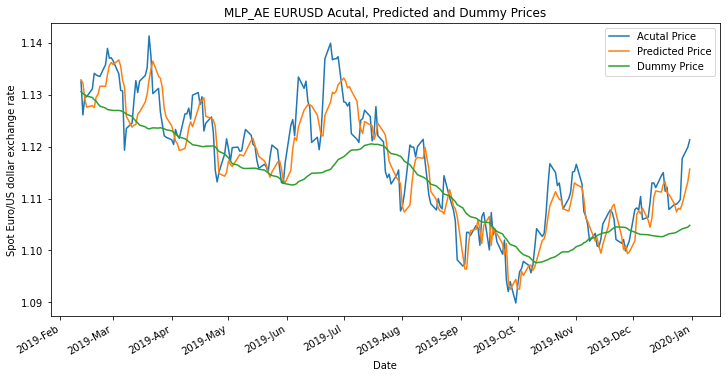

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

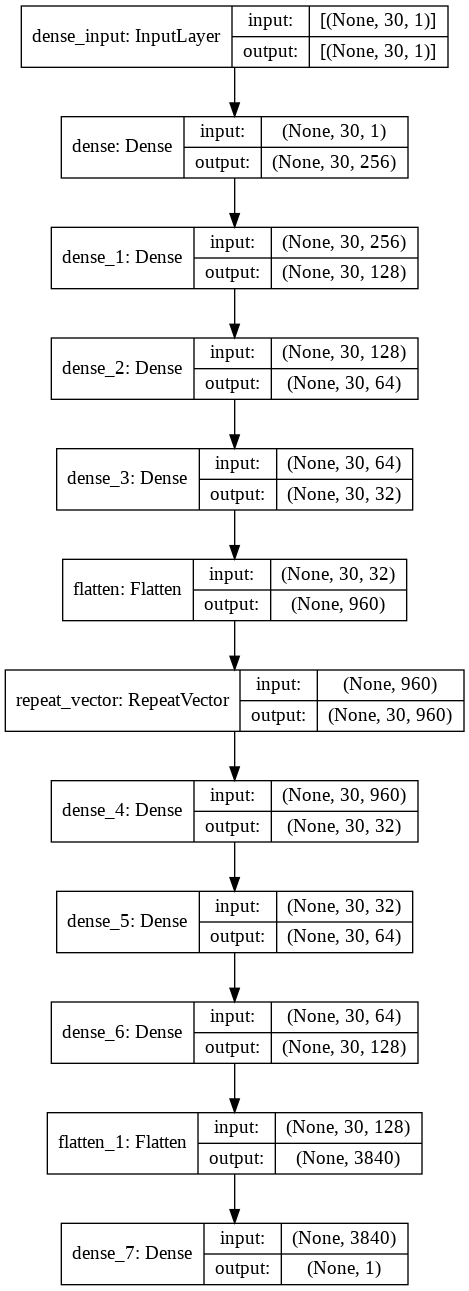

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.021536919802686755
RMSE:  0.14675462446780596
MAE:  0.12310162065338942
Dummy MSE:  0.0236885518332631
Dummy RMSE:  0.15391085677515767
Dummy MAE:  0.11970302826636056


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_EURUSD/assets
